In [ ]:
!pip install xgboost
!pip install plotly

In [ ]:
import logging
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Callable, Optional, Dict, List, Tuple, Any
import json
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.base import clone

In [ ]:
class FeatureEngineer:
    """
    用於特徵工程的工具類別。所有方法皆為靜態方法，
    代表獨立的預處理管道。
    """

    @staticmethod
    def map_columns(df: pd.DataFrame, mappings: Dict[str, Dict]) -> pd.DataFrame:
        """
        根據提供的字典進行欄位映射。
        Args:
            df: 待處理的 DataFrame。
            mappings: 欄位名到映射字典的字典，例如 {'Gender': {'Male': 0, 'Female': 1}}。
        Returns:
            映射後的 DataFrame 副本。
        """
        df_copy = df.copy()
        for col, mapping in mappings.items():
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].map(mapping)
        return df_copy

    @staticmethod
    def cast_columns(df: pd.DataFrame,
                    int_cols: Optional[List[str]] = None,
                    cat_cols: Optional[List[str]] = None) -> pd.DataFrame:
        """
        轉換指定欄位的數據類型。
        Args:
            df: 待處理的 DataFrame。
            int_cols: 應轉換為 int 類型的欄位列表。
            cat_cols: 應轉換為 'category' 類型的欄位列表。
        Returns:
            轉換類型後的 DataFrame 副本。
        """
        df_copy = df.copy()
        if int_cols:
            for col in int_cols:
                if col in df_copy.columns:
                    df_copy[col] = df_copy[col].astype(int)
        if cat_cols:
            for col in cat_cols:
                if col in df_copy.columns:
                    df_copy[col] = df_copy[col].astype('category')
        return df_copy

    @staticmethod
    def run_v0_baseline(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        基礎管道：僅進行類型轉換，不創建新特徵。

        🔧 修正：統一在最後移除 Exited，避免重複處理

        Args:
            df: 原始 DataFrame。
            is_train: 是否為訓練集（用於決定是否移除 'Exited' 欄位）。
        """
        df_copy = df.copy()

        # 性別映射
        gender_map = {'Male': 0, 'Female': 1}
        df_copy = FeatureEngineer.map_columns(df_copy, {'Gender': gender_map})

        #國家 one hot
        df_copy['Geography_Germany'] = (df_copy['Geography'] == 'Germany').astype(int)
        df_copy['Geography_France'] = (df_copy['Geography'] == 'France').astype(int)
        df_copy['Geography_Spain'] = (df_copy['Geography'] == 'Spain').astype(int)

        # 類型轉換

        int_cols = ['HasCrCard', 'IsActiveMember', 'Gender','Geography_Spain','Geography_France','Geography_Germany']
        cat_cols = []
        df_copy = FeatureEngineer.cast_columns(df_copy, int_cols=int_cols, cat_cols=cat_cols)

        # 移除不需要的欄位
        cols_to_drop = ['id', 'CustomerId', 'Surname','Geography']

        # ✅ 修正：統一在最後處理 Exited
        if is_train and 'Exited' in df_copy.columns:
            cols_to_drop.append('Exited')

        df_copy.drop(columns=[col for col in cols_to_drop if col in df_copy.columns],
                    inplace=True, errors='ignore')

        return df_copy

    @staticmethod
    def run_v1_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        版本 1：基礎旗標和分箱。

        特徵：
        - Age_bin: 年齡分箱
        """
        # ⚠️ 注意：這裡 is_train=False 是為了保留 Exited 到最後再移除
        df_copy = FeatureEngineer.run_v0_baseline(df, is_train=False)

        # 年齡分箱
        df_copy['Age_bin'] = pd.cut(
            df_copy['Age'],
            bins=[0, 25, 35, 45, 60, np.inf],
            labels=['0', '1', '2', '3', '4']
        )

        # 類型轉換
        int_cols = ['HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Age_bin']
        cat_cols = ['Geography']
        df_copy = FeatureEngineer.cast_columns(df_copy, int_cols=int_cols, cat_cols=cat_cols)

        # ✅ 統一移除不需要的欄位
        cols_to_drop = ['id', 'CustomerId', 'Surname']
        if is_train and 'Exited' in df_copy.columns:
            cols_to_drop.append('Exited')

        df_copy.drop(columns=[col for col in cols_to_drop if col in df_copy.columns],
                    inplace=True, errors='ignore')

        return df_copy

    @staticmethod
    def run_v2_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        版本 2：餘額特徵

        特徵：
        - Has_Balance: 是否有餘額（二元特徵）
        """
        df_copy = FeatureEngineer.run_v0_baseline(df, is_train=False)

        # 餘額特徵
        df_copy['Has_Balance'] = (df_copy['Balance'] > 0).astype(int)

        # 移除 Exited
        if is_train and 'Exited' in df_copy.columns:
            df_copy.drop(columns=['Exited'], inplace=True, errors='ignore')

        return df_copy

    @staticmethod
    def run_v3_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        版本 3：Log 轉換 + 餘額特徵

        特徵：
        - Tenure_log
        - Has_Balance: 是否有餘額
        """
        df_copy = FeatureEngineer.run_v2_preprocessing(df, is_train=False)

        # Log 轉換
        df_copy['Balance_log'] = np.log1p(df_copy['Balance'])

        cols_to_drop = ['Balance']
        if is_train and 'Exited' in df_copy.columns:
            cols_to_drop.append('Exited')

        df_copy.drop(columns=[col for col in cols_to_drop if col in df_copy.columns],
                    inplace=True, errors='ignore')

        return df_copy


In [ ]:
class ModelTrainer:
    """協調器類別，用於統一模型訓練、評估和預測的流程。"""

    def __init__(self, n_splits: int = 5, random_state: int = 42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.logger = logging.getLogger(self.__class__.__name__)

        # CV splits 管理
        self._cv_splits = None  # 儲存 splits 的容器
        self._cv_splits_metadata = {}  # 儲存 splits 的元資料

        if not self.logger.handlers:
            logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # ========================================================================
    # CV Splits 管理方法
    # ========================================================================

    def _generate_cv_splits(self, X: pd.DataFrame, y: pd.Series, force_regenerate: bool = False) -> List[Tuple]:
        """
        生成 K-Fold CV splits 並儲存，確保後續使用相同的分割

        Parameters:
        -----------
        X : pd.DataFrame
            特徵資料
        y : pd.Series
            目標變數
        force_regenerate : bool
            是否強制重新生成（即使已存在）

        Returns:
        --------
        splits : list of tuples
            [(train_idx_fold1, val_idx_fold1), (train_idx_fold2, val_idx_fold2), ...]
        """
        if self._cv_splits is None or force_regenerate:
            self.logger.info(f"🔑 生成 {self.n_splits}-Fold CV splits (random_state={self.random_state})")
            skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
            self._cv_splits = [(train_idx, val_idx) for train_idx, val_idx in skf.split(X, y)]

            # 儲存元資料
            self._cv_splits_metadata = {
                'n_splits': self.n_splits,
                'random_state': self.random_state,
                'n_samples': len(X),
                'class_distribution': y.value_counts().to_dict()
            }

            self.logger.info("✓ CV splits 已生成並儲存")
            self.logger.info(f"  樣本數: {len(X)}, 類別分布: {self._cv_splits_metadata['class_distribution']}")
        else:
            self.logger.info("✓ 使用已儲存的 CV splits（確保與前次實驗相同）")

        return self._cv_splits

    def get_cv_splits(self) -> Optional[List[Tuple]]:
        """取得當前儲存的 CV splits"""
        return self._cv_splits

    def save_cv_splits(self, filepath: str = 'cv_splits.pkl'):
        """
        儲存 CV splits 到檔案

        Parameters:
        -----------
        filepath : str
            儲存路徑
        """
        if self._cv_splits is None:
            self.logger.warning("尚未生成 CV splits，無法儲存")
            return

        with open(filepath, 'wb') as f:
            pickle.dump({
                'splits': self._cv_splits,
                'metadata': self._cv_splits_metadata
            }, f)

        self.logger.info(f"✓ CV splits 已儲存至: {filepath}")

    def load_cv_splits(self, filepath: str = 'cv_splits.pkl'):
        """
        從檔案載入 CV splits

        Parameters:
        -----------
        filepath : str
            載入路徑
        """
        with open(filepath, 'rb') as f:
            data = pickle.load(f)

        self._cv_splits = data['splits']
        self._cv_splits_metadata = data['metadata']

        self.logger.info(f"✓ CV splits 已從 {filepath} 載入")
        self.logger.info(f"  元資料: {self._cv_splits_metadata}")

    def reset_cv_splits(self):
        """重置 CV splits（開始新的實驗系列）"""
        self._cv_splits = None
        self._cv_splits_metadata = {}
        self.logger.info("CV splits 已重置")


    # ========================================================================
    # 使用給定參數訓練模型
    # ========================================================================

    def train_with_params(self,
                         train_df: pd.DataFrame,
                         test_df: pd.DataFrame,
                         feature_engineering_pipeline: Callable,
                         model_params: Dict,
                         target_col: str = 'Exited',
                         cv_splits: Optional[List[Tuple]] = None) -> Tuple[pd.DataFrame, Dict]:
        """
        使用給定的超參數訓練模型

        Parameters:
        -----------
        train_df : pd.DataFrame
            訓練資料
        test_df : pd.DataFrame
            測試資料
        feature_engineering_pipeline : Callable
            特徵工程函數
        model_params : dict
            模型超參數
        target_col : str
            目標變數欄位名
        cv_splits : list, optional
            預先定義的 CV splits

        Returns:
        --------
        submission_df : pd.DataFrame
            提交檔案
        results : dict
            訓練結果（包含 OOF 預測、測試預測、指標等）
        """
        self.logger.info("=" * 60)
        self.logger.info(f"🚀 開始訓練: {feature_engineering_pipeline.__name__}")
        self.logger.info("=" * 60)

        test_ids = test_df['id'].copy()
        y_train = train_df[target_col].astype(int)

        # 1. 特徵工程
        self.logger.info("步驟 1: 應用特徵工程...")
        X_train_processed = feature_engineering_pipeline(train_df, is_train=True)
        X_test_processed = feature_engineering_pipeline(test_df, is_train=False)

        # 對齊欄位
        train_cols = X_train_processed.columns
        test_cols = X_test_processed.columns
        if not train_cols.equals(test_cols):
            self.logger.warning("訓練集和測試集的欄位不一致! 正在對齊...")
            shared_cols = list(train_cols.intersection(test_cols))
            X_train_processed = X_train_processed[shared_cols]
            X_test_processed = X_test_processed[shared_cols]

        # 2. 生成或使用 CV splits
        if cv_splits is None:
            cv_splits = self._generate_cv_splits(X_train_processed, y_train)
        else:
            self.logger.info("✓ 使用外部提供的 CV splits")

        # 3. 創建模型
        model = XGBClassifier(**model_params)
        models = {'XGBoost': model}

        # 4. 訓練與評估
        self.logger.info("步驟 2: 訓練模型...")
        all_results = self._evaluate_models(
            models,
            X_train_processed,
            y_train,
            X_test_processed,
            cv_splits=cv_splits
        )

        # 5. 生成提交文件
        model_name = list(all_results.keys())[0]
        self.logger.info("步驟 3: 生成提交文件...")
        submission_df = self._generate_submission(
            f"submission_{model_name}_{feature_engineering_pipeline.__name__}.csv",
            test_ids,
            all_results[model_name]['test_preds']
        )

        self.logger.info("=" * 60)
        self.logger.info("✅ 訓練完成")
        self.logger.info("=" * 60)

        return submission_df, all_results


    # ========================================================================
    # 原有方法（保留向後相容）
    # ========================================================================

    def run_experiment(self,
                       train_df: pd.DataFrame,
                       test_df: pd.DataFrame,
                       feature_engineering_pipeline: Callable,
                       models: dict,
                       target_col: str = 'Exited',
                       cv_splits: Optional[list] = None) -> tuple:
        """標準實驗流程（向後相容）"""
        test_ids = test_df['id'].copy()
        y_train = train_df[target_col].astype(int)

        X_train_processed = feature_engineering_pipeline(train_df, is_train=True)
        X_test_processed = feature_engineering_pipeline(test_df, is_train=False)

        train_cols = X_train_processed.columns
        test_cols = X_test_processed.columns
        if not train_cols.equals(test_cols):
            shared_cols = list(train_cols.intersection(test_cols))
            X_train_processed = X_train_processed[shared_cols]
            X_test_processed = X_test_processed[shared_cols]

        if cv_splits is None:
            cv_splits = self._generate_cv_splits(X_train_processed, y_train)

        all_results = self._evaluate_models(
            models, X_train_processed, y_train, X_test_processed, cv_splits=cv_splits
        )

        best_roc_auc = -1.0
        best_model_name = None
        for name, result in all_results.items():
            current_auc = result['metrics_df']['ROC AUC'].mean()
            if current_auc > best_roc_auc:
                best_roc_auc = current_auc
                best_model_name = name

        submission_df = self._generate_submission(
            f"submission_{best_model_name}_{feature_engineering_pipeline.__name__}.csv",
            test_ids,
            all_results[best_model_name]['test_preds']
        )

        return submission_df, all_results

    def _evaluate_models(self,
                        models: dict,
                        X_train: pd.DataFrame,
                        y_train: pd.Series,
                        X_test: pd.DataFrame,
                        cv_splits: Optional[list] = None) -> dict:
        """使用交叉驗證訓練和驗證模型"""
        if cv_splits is None:
            cv_splits = self._generate_cv_splits(X_train, y_train)

        results = {}
        cat_feature_names = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

        for name, model in models.items():
            self.logger.info(f"正在訓練模型: {name}")
            oof_preds = np.zeros(len(X_train))
            test_preds_folds, fold_metrics_list, importances_folds = [], [], []

            for fold, (train_idx, val_idx) in enumerate(cv_splits):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                current_model = clone(model)
                fit_params = {}

                if isinstance(current_model, XGBClassifier):
                    fit_params['eval_set'] = [(X_val, y_val)]
                    fit_params['verbose'] = False

                current_model.fit(X_tr, y_tr, **fit_params)

                proba_val = current_model.predict_proba(X_val)[:, 1]
                proba_test = current_model.predict_proba(X_test)[:, 1]

                oof_preds[val_idx] = proba_val
                test_preds_folds.append(proba_test)

                fold_metrics_list.append({
                    'ROC AUC': roc_auc_score(y_val, proba_val),
                    'PR AUC': average_precision_score(y_val, proba_val)
                })

                if hasattr(current_model, 'feature_importances_'):
                    importances_folds.append(current_model.feature_importances_)

            results[name] = {
                'oof_preds': oof_preds,
                'test_preds': np.mean(test_preds_folds, axis=0),
                'metrics_df': pd.DataFrame(fold_metrics_list),
                'feature_importances': np.mean(importances_folds, axis=0) if importances_folds else None,
                'feature_names': X_train.columns
            }
            self.logger.info(
                f"  模型 {name} | CV ROC AUC: {results[name]['metrics_df']['ROC AUC'].mean():.4f} ± {results[name]['metrics_df']['ROC AUC'].std():.4f}"
            )

        return results

    def _generate_submission(self, filename: str, df_test_id: pd.Series, test_preds: np.ndarray) -> pd.DataFrame:
        if filename == 'submission_CatBoost_final_run_v3_preprocessing.csv':
            filename = 'submission.csv'

        submission_df = pd.DataFrame({'id': df_test_id, 'Exited': test_preds})
        submission_df.to_csv(filename, index=False)
        self.logger.info(f"提交文件成功保存: {filename}")
        return submission_df

In [ ]:
trainer = ModelTrainer()

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [ ]:
final_best_params = {
    "n_estimators": 2359,
    "learning_rate": 0.03198713759881074,
    "max_depth": 5,
    "min_child_weight": 3,
    "reg_lambda": 6.022982092917193e-08,
    "reg_alpha": 0.003458899804040248,
    "gamma": 0.0002651655957741115,
    "subsample": 0.7754049349326726,
    "colsample_bytree": 0.6581574816325996,
    "colsample_bylevel": 0.8754537493172686,
    "random_state": 42,
    "verbose": 0,
    "eval_metric": "auc",
    "n_jobs": -1,
    "verbosity": 0,
    "enable_categorical": True,
    "early_stopping_rounds": 50
}

# 實例化最終模型
final_tuned_model = XGBClassifier(**final_best_params)

# 創建包含最終模型的字典
models_final = {
    'XGBoost_Final_Tuned': final_tuned_model
}

In [ ]:
# 準備訓練資料
print("在全部訓練資料上訓練最終模型...")
y_train = df_train['Exited'].astype(int)
X_train_processed = FeatureEngineer.run_v3_preprocessing(df_train, is_train=True)

# 建立參數副本並移除 early_stopping_rounds
#final_params_no_early_stop = test_params.copy()
final_params_no_early_stop = final_best_params.copy()
final_params_no_early_stop.pop('early_stopping_rounds', None)  # 安全移除

# 訓練模型
final_tuned_model = XGBClassifier(**final_params_no_early_stop)
final_tuned_model.fit(X_train_processed, y_train)

# 儲存模型
final_tuned_model.save_model("xgb_model.json")
print("✅ 模型已成功儲存為 xgb_model.json")

在全部訓練資料上訓練最終模型...
✅ 模型已成功儲存為 xgb_model.json


In [ ]:
!pip install shap

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X_train_processed = FeatureEngineer.run_v3_preprocessing(df_train, is_train=True)

#X_train_processed = FeatureEngineer.run_v0_baseline(df_train, is_train=True)
#X_test_processed = FeatureEngineer.run_v0_baseline(df_test, is_train=False)

# 確保欄位一致性 (與 ModelTrainer 邏輯相同)
train_cols = X_train_processed.columns

print(f"訓練集樣本數: {X_train_processed.shape[0]}, 特徵數量: {X_train_processed.shape[1]}")

# --- 步驟 2: 建立 SHAP 解釋器 (Explainer) ---
# 確保 final_tuned_model 已經訓練完成
explainer = shap.TreeExplainer(final_tuned_model)


# --- 步驟 3: 計算 SHAP 值 ---

# --- SHAP 計算部分修正 ---

print("\n計算訓練集 (Train) SHAP 值 (使用 explainer())...")

train_explanation = explainer(X_train_processed)

train_shap_matrix = train_explanation.values


print(f"train_shap_matrix 的形狀: {train_shap_matrix.shape}")



# --- 視覺化 (使用新的 SHAP 矩陣) ---

plt.figure(figsize=(18, 6))

# A. 訓練集 SHAP 摘要圖
plt.subplot(1, 2, 1)
plt.title("Train Set SHAP Summary Plot (Predicting Exited=1)", fontsize=14)
# 傳入 train_shap_matrix
shap.summary_plot(
    train_shap_matrix,  # <--- 使用修正後的 2D 矩陣
    X_train_processed,
    show=False,
    plot_size=None,
    max_display=15
)


plt.tight_layout()
plt.show()

print("\n✅ Train SHAP 摘要圖已生成。")

訓練集樣本數: 15000, 特徵數量: 13

計算訓練集 (Train) SHAP 值 (使用 explainer())...


KeyboardInterrupt: 

預測流失機率: 0.1797


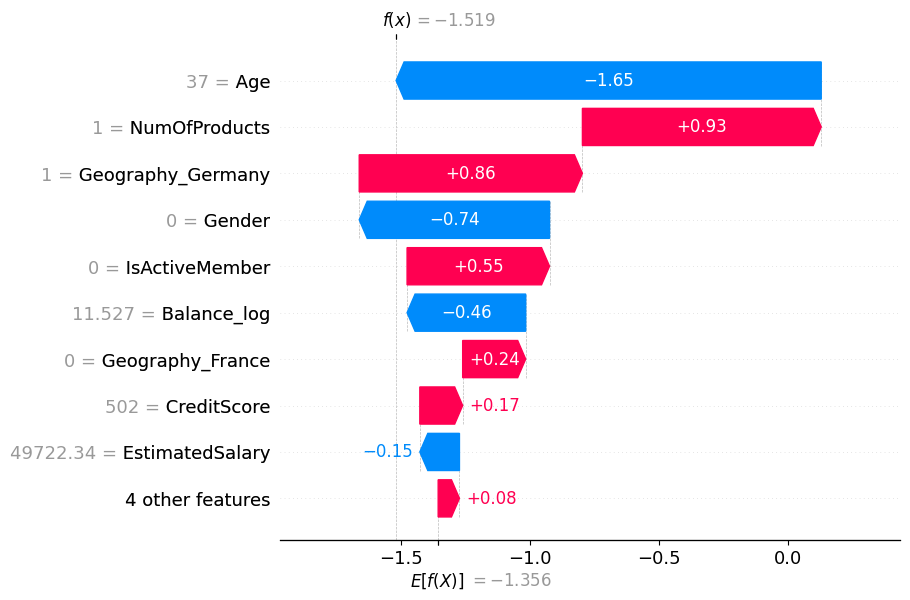

<Figure size 640x480 with 0 Axes>

In [ ]:
import shap
import matplotlib.pyplot as plt

# 直接使用 final_tuned_model 建立 SHAP 解釋器
explainer = shap.TreeExplainer(final_tuned_model)

# 準備資料
X_train_processed = FeatureEngineer.run_v3_preprocessing(df_train, is_train=True)

# 分析單筆資料
sample_idx = 3823
single_instance = X_train_processed.iloc[sample_idx:sample_idx+1]

# 計算 SHAP 值
shap_values = explainer.shap_values(single_instance)

# 預測
prediction = final_tuned_model.predict_proba(single_instance)[0, 1]
print(f"預測流失機率: {prediction:.4f}")

# 視覺化
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=single_instance.iloc[0],
    feature_names=X_train_processed.columns.tolist()
))
plt.tight_layout()
plt.show()

In [ ]:
FeatureEngineer.run_v3_preprocessing(df_train, is_train=False)

,CreditScore,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_France,Geography_Spain,Has_Balance,Balance_log
0,675.0,1,48.0,7.0,2.0,0,0,93844.82,1.0,0,1,0,1,11.874675
1,673.0,1,37.0,7.0,2.0,0,0,170980.86,0.0,0,1,0,0,0.000000
2,607.0,0,29.0,4.0,2.0,0,1,61290.99,0.0,0,1,0,0,0.000000
3,669.0,1,28.0,2.0,2.0,1,0,97734.30,0.0,0,1,0,0,0.000000
4,743.0,0,24.0,7.0,2.0,1,0,180800.42,0.0,0,1,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,624.0,1,37.0,4.0,1.0,1,1,91830.75,0.0,0,1,0,0,0.000000
14996,796.0,1,42.0,1.0,1.0,1,0,18922.18,1.0,1,0,0,1,11.797691
14997,664.0,1,24.0,9.0,2.0,1,1,121402.53,0.0,1,0,0,1,11.679284
14998,587.0,0,42.0,6.0,1.0,0,0,119377.44,1.0,1,0,0,1,11.705730
